In [ ]:
#!pip install scipy==1.11.4
!pip install dalex
#!pip install scikit-plot
!pip install shap
!pip install lime

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from xgboost import XGBClassifier

import dalex as dx

#import scikitplot as skplt

import shap

from lime.lime_tabular import LimeTabularExplainer

# GITHUB

# Load Data

In [ ]:
pd.set_option("display.max_columns", None)
df = pd.read_csv('https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/bank_churn_dataset/bank_churn_data.csv')
df.head()

user_id     attrition_flag  customer_age gender  dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  education_level marital_status income_category card_category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   months_on_book  total_relationship_count  months_inactive_12_mon  \
0              39                         5                       1   
1              44                         6                       1   
2              36                         4                       1   
3              34                         3                       4   
4              21                         5                       1   

   contacts_count_12_mon  credit_limit  total_revolving_bal  avg_open_to_buy  \
0                      3       12691.0                  777          11914.0   
1                      2        8256.0                  864           7392.0   
2                      0        3418.0                    0           3418.0   
3                      1        3313.0                 2517            796.0   
4                      0        4716.0                    0           4716.0   

   total_amt_chng_q4_q1  total_trans_amt  total_trans_ct  total_ct_chng_q4_q1  \
0                 1.335             1144              42                1.625   
1                 1.541             1291              33                3.714   
2                 2.594             1887              20                2.333   
3                 1.405             1171              20                2.333   
4                 2.175              816              28                2.500   

   avg_utilization_ratio  
0                  0.061  
1                  0.105  
2                  0.000  
3                  0.760  
4                  0.000

## Data understanding

- user_id: customer account number.
- attrition_flag: customer status (Existing and Attrited).
- customer_age: age of the customer.
- gender: gender of customer (M for male and F for female).
- dependent_count: number of dependents of customers.
- education_level: customer education level (Uneducated, High School, Graduate, College, Post-Graduate, Doctorate, and Unknown).
- marital_status: customer's marital status (Single, Married, Divorced, and Unknown).
- income_category: customer income interval category (Less than $40K, $40K-$60k, $60K-$80K, $80K-$120K, $120K +, and Unknown).
- card_category: type of card used (Blue, Silver, Gold, and Platinum).
- months_on_book: period of being a customer (in months).
- total_relationship_count: the number of products used by customers in the bank.
- months_inactive_12_mon: period of inactivity for the last 12 months.
- contacts_count_12_mon: the number of interactions between the bank and the customer in the last 12 months.
- credit_limit: credit card transaction nominal limit in one period.
- total_revolving_bal: total funds used in one period.
- avg_open_to_buy: the difference between the credit limit set for the cardholder's account and the current balance.
- total_amt_chng_q4_q1: increase in customer transaction nominal between quarter 4 and quarter 1.
- total_trans_amt: total nominal transaction in the last 12 months.
- total_trans_ct: the number of transactions in the last 12 months.
- total_ct_chng_q4_q1: the number of customer transactions increased between quarter 4 and quarter 1.
- avg_utilization_ratio: percentage of credit card usage.


## Data inspection

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   10127 non-null  int64  
 1   attrition_flag            10127 non-null  object 
 2   customer_age              10127 non-null  int64  
 3   gender                    10127 non-null  object 
 4   dependent_count           10127 non-null  int64  
 5   education_level           10127 non-null  object 
 6   marital_status            10127 non-null  object 
 7   income_category           10127 non-null  object 
 8   card_category             10127 non-null  object 
 9   months_on_book            10127 non-null  int64  
 10  total_relationship_count  10127 non-null  int64  
 11  months_inactive_12_mon    10127 non-null  int64  
 12  contacts_count_12_mon     10127 non-null  int64  
 13  credit_limit              10127 non-null  float64
 14  total_

- Tidak ada Missing Value
- tipe data sudah sesuai

In [ ]:
df.duplicated().sum()

0

Tidak ada data duplikat

# Problem to Solve

Beberapa yang harus anda lakukan:<br>
1. Analisa beberapa pertanyaan berikut berdasarkan data yang diberikan:<br>
  - Seperti apa distribusi usia para nasabah? Usia manakah yang cenderung memiliki kemungkinan churn terbesar?
  - Apakah terdapat korelasi antara tingkat pendidikan dan income category? Bagaimana korelasi dari kedua prediktor tersebut terhadap churn?
  - Apakah terdapat perbedaan yang signifikan antara gender dengan kemungkinan nasabah untuk churn?
  - Apakah semakin lama customer menjadi nasabah maka semakin kecil kemungkinan nasabah tersebut untuk churn?
  - Apakah semakin sering customer berinteraksi dengan bank dalam 1 tahun terakhir mempengaruhi besar atau kecilnya kemungkinan nasabah untuk churn?

2. Buatlah model prediksi dengan menggunakan model machine learning (bebas, tidak dibatasi) dan evaluasi seberapa baik model yang anda buat. Catatan: soal ini akan dinilai berdasarkan apakah mentee sudah menggunakan workflow dengan benar

3. Anda ingin meyakinkan stakeholder anda bahwa model yang anda gunakan itu akan lebih baik dalam mengidentifikasi customer yang akan churn dibandingkan tanpa menggunakan model. Apa metrik yang dapat anda gunakan untuk membuktikan hal ini? Visualkan!

4. (Open-Ended) Karena stakeholder anda membutuhkan knowledge dari model, analisislah model yang anda buat dengan menggunakan explanatory model analysis dan buatlah rekomendasi-rekomendasi berdasarkan hasil dari analisis tersebut
Catatan: Gunakan hanya salah satu dari 3 metode ini tergantung jenis modelnya:
Jika model yang dipilih adalah model yang interpretable, gunakan teknik interpretasi sesuai dengan model yang dipilih
Jika model yang dipilih adalah model yang non-interpretable, gunakan metode model agnostics berikut:
Permutation Feature Importance + Partial Dependence Plot
Shapley Additive Value Feature Importance + Shapley Dependence Plot


# Simple EDA

Buang `user_id` karena tidak diperlukan dalam analis ini

In [ ]:
df = df.drop('user_id', axis = 1)

## Statictical Descriptive

In [ ]:
df.describe().T

count         mean          std     min       25%  \
customer_age              10127.0    46.325960     8.016814    26.0    41.000   
dependent_count           10127.0     2.346203     1.298908     0.0     1.000   
months_on_book            10127.0    35.928409     7.986416    13.0    31.000   
total_relationship_count  10127.0     3.812580     1.554408     1.0     3.000   
months_inactive_12_mon    10127.0     2.341167     1.010622     0.0     2.000   
contacts_count_12_mon     10127.0     2.455317     1.106225     0.0     2.000   
credit_limit              10127.0  8631.953698  9088.776650  1438.3  2555.000   
total_revolving_bal       10127.0  1162.814061   814.987335     0.0   359.000   
avg_open_to_buy           10127.0  7469.139637  9090.685324     3.0  1324.500   
total_amt_chng_q4_q1      10127.0     0.759941     0.219207     0.0     0.631   
total_trans_amt           10127.0  4404.086304  3397.129254   510.0  2155.500   
total_trans_ct            10127.0    64.858695    23.472570    10.0    45.000   
total_ct_chng_q4_q1       10127.0     0.712222     0.238086     0.0     0.582   
avg_utilization_ratio     10127.0     0.274894     0.275691     0.0     0.023   

                               50%        75%        max  
customer_age                46.000     52.000     73.000  
dependent_count              2.000      3.000      5.000  
months_on_book              36.000     40.000     56.000  
total_relationship_count     4.000      5.000      6.000  
months_inactive_12_mon       2.000      3.000      6.000  
contacts_count_12_mon        2.000      3.000      6.000  
credit_limit              4549.000  11067.500  34516.000  
total_revolving_bal       1276.000   1784.000   2517.000  
avg_open_to_buy           3474.000   9859.000  34516.000  
total_amt_chng_q4_q1         0.736      0.859      3.397  
total_trans_amt           3899.000   4741.000  18484.000  
total_trans_ct              67.000     81.000    139.000  
total_ct_chng_q4_q1          0.702      0.818      3.714  
avg_utilization_ratio        0.176      0.503      0.999

In [ ]:
df.describe(include='object').T

count unique                top  freq
attrition_flag   10127      2  Existing Customer  8500
gender           10127      2                  F  5358
education_level  10127      7           Graduate  3128
marital_status   10127      4            Married  4687
income_category  10127      6     Less than $40K  3561
card_category    10127      4               Blue  9436

## Univariate Analysis

<Axes: xlabel='attrition_flag', ylabel='count'>

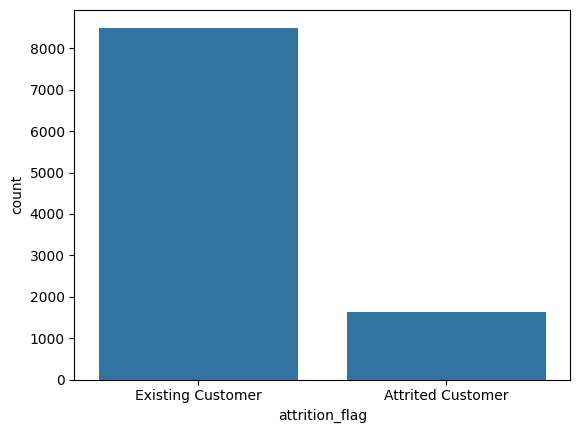

In [ ]:
sns.countplot(df, x = 'attrition_flag')

Target imbalance, lebih banyak nasabah yang masih berlangganan dari pada nasabah yang berhenti berlangganan.

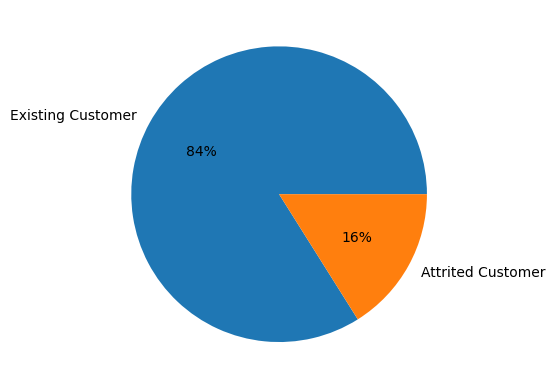

In [ ]:
attrition_counts = df['attrition_flag'].value_counts()

plt.pie(attrition_counts, labels=attrition_counts.index, autopct='%.0f%%')

plt.show()

In [ ]:
num = df.select_dtypes(include = 'number').columns
cat = df.select_dtypes(include = 'object').columns

In [ ]:
len(num)

14

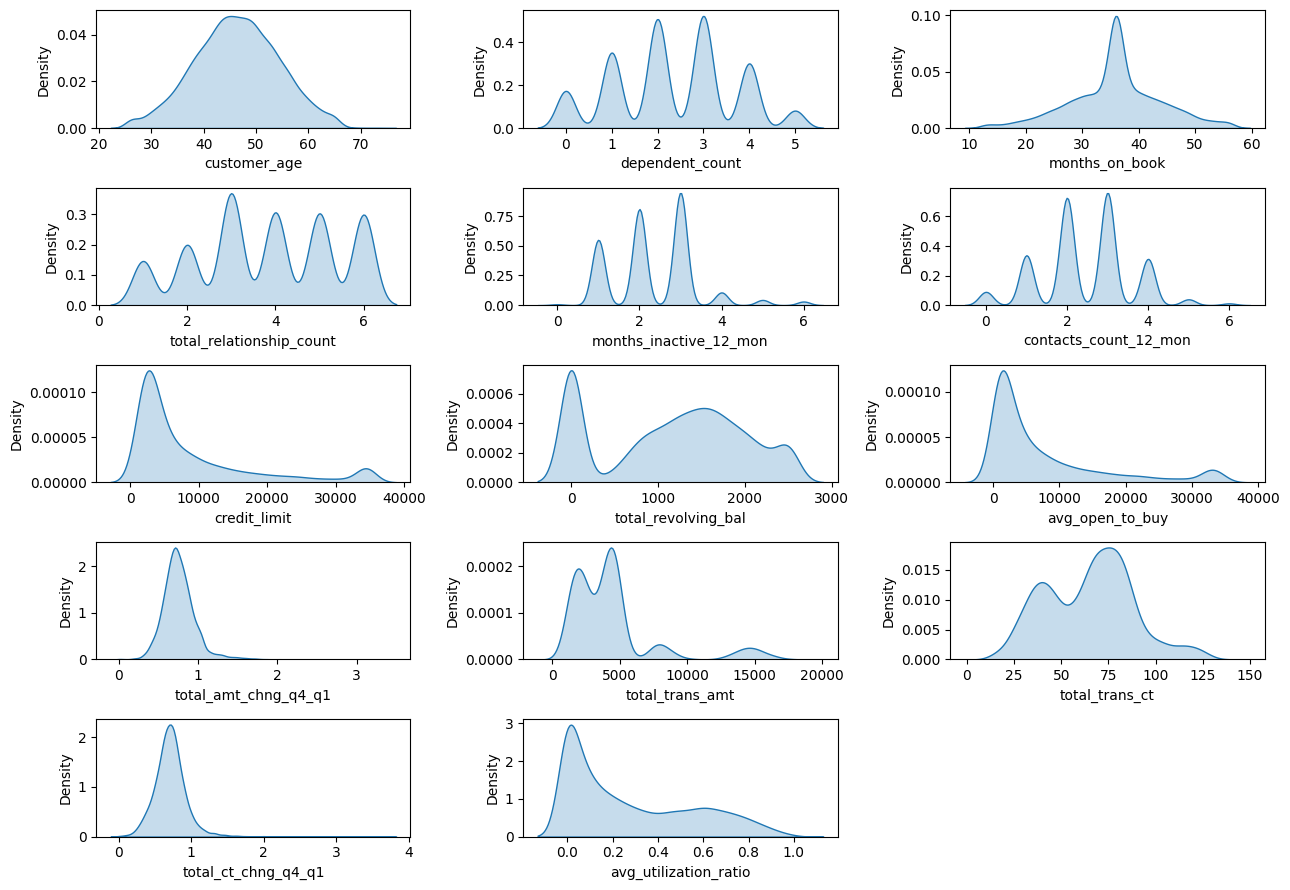

In [ ]:
plt.figure(figsize=(13,9))
for i in range(0, len(num)):
    plt.subplot(5,3, i+1)
    sns.kdeplot(data=df, x=df[num[i]], fill='True')
    plt.tight_layout()

In [ ]:
num

Index(['customer_age', 'dependent_count', 'months_on_book',
       'total_relationship_count', 'months_inactive_12_mon',
       'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal',
       'avg_open_to_buy', 'total_amt_chng_q4_q1', 'total_trans_amt',
       'total_trans_ct', 'total_ct_chng_q4_q1', 'avg_utilization_ratio'],
      dtype='object')

`months_inactive_12_mon`, `dependent_count`, `total_relationship_count`, `contacts_count_12_mon`, `total_ct_chng_q4_q1`, `total_amt_chng_q4_q1` merupakan kategorical. ubah data menjadi object

In [ ]:
df[['months_inactive_12_mon', 'dependent_count', 'total_relationship_count', 'contacts_count_12_mon']] = df[['months_inactive_12_mon', 'dependent_count', 'total_relationship_count', 'contacts_count_12_mon']].astype('object')

## Multi Variate Analysis

In [ ]:
num = df.select_dtypes(include = 'number').columns
cat = df.select_dtypes(include = 'object').columns

<Axes: >

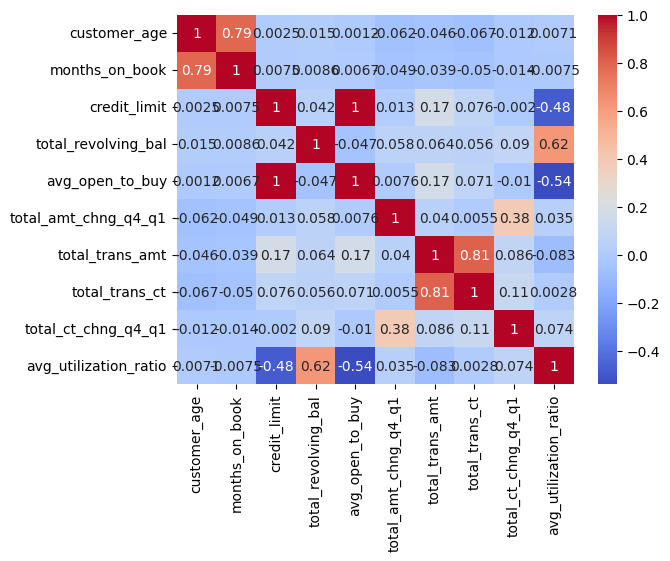

In [ ]:
corr = df[num].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

Insight!
- `month_on_book` memiliki korelasi positif yang kuat dengan `custoomer_age`
- `total_trans_amt` memiliki korelai positif yang kuat dengan `total_trans_ct`
- `total_revolving_bal` memiliki korelasi positif yang cukup kuat denngan `avg_utilization_ratio`
- `avg_open_to_buy` memiliki korelasi negatif yang cukup kuat dengan `avg_utilization_ratio`

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   attrition_flag            10127 non-null  object 
 1   customer_age              10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  object 
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   income_category           10127 non-null  object 
 7   card_category             10127 non-null  object 
 8   months_on_book            10127 non-null  int64  
 9   total_relationship_count  10127 non-null  object 
 10  months_inactive_12_mon    10127 non-null  object 
 11  contacts_count_12_mon     10127 non-null  object 
 12  credit_limit              10127 non-null  float64
 13  total_revolving_bal       10127 non-null  int64  
 14  avg_op

## Outliers

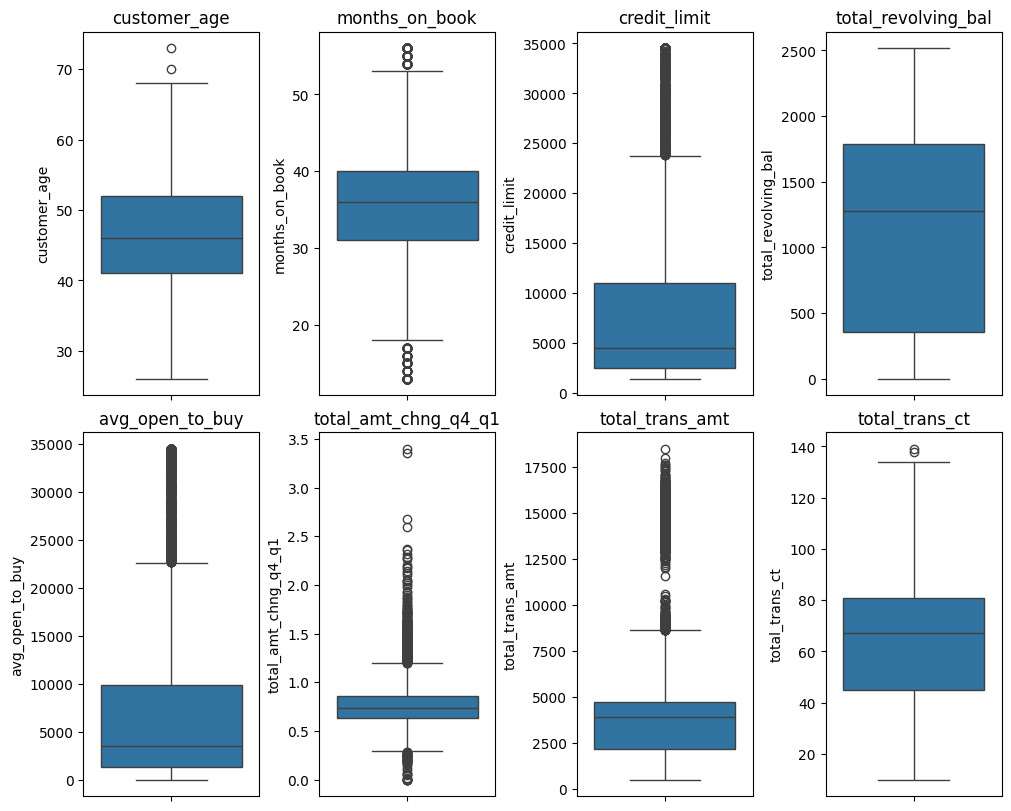

In [ ]:
fig, axes = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(10, 8), constrained_layout=True)

col_index = 0

# Iterate through subplots correctly using nested loops
for i in range(axes.shape[0]):  # Iterate through rows
    for j in range(axes.shape[1]):  # Iterate through columns
        sns.boxplot(ax=axes[i, j], y=df[num[col_index]])  # Access subplot with (i, j)
        axes[i, j].set_title(num[col_index])
        col_index += 1

avg_utilization_ratio, avg_open_to_buy, total_trans_amt, credit_limit, months_on_book

In [ ]:
from scipy import stats
import numpy as np


print(f'Total Rows BEFORE Outlier Handling = {len(df)}')

filtered_entries = np.array([True] * len(df))

for col in num:
    zscore = abs(stats.zscore(df[col]))
    filtered_entries = (zscore < 3) & filtered_entries

df = df[filtered_entries]

print(f'Total Rows AFTER Outlier Handling = {len(df)}')

Total Rows BEFORE Outlier Handling = 10127
Total Rows AFTER Outlier Handling = 9485


# Split train, val, test

In [ ]:
df.head()

attrition_flag  customer_age gender dependent_count education_level  \
5   Existing Customer            44      M               2        Graduate   
10  Existing Customer            42      M               5      Uneducated   
14  Existing Customer            57      F               2        Graduate   
19  Existing Customer            45      F               2        Graduate   
20  Existing Customer            47      M               1       Doctorate   

   marital_status income_category card_category  months_on_book  \
5         Married     $40K - $60K          Blue              36   
10        Unknown         $120K +          Blue              31   
14        Married  Less than $40K          Blue              48   
19        Married         Unknown          Blue              37   
20       Divorced     $60K - $80K          Blue              42   

   total_relationship_count months_inactive_12_mon contacts_count_12_mon  \
5                         3                      1                     2   
10                        5                      3                     2   
14                        5                      2                     2   
19                        6                      1                     2   
20                        5                      2                     0   

    credit_limit  total_revolving_bal  avg_open_to_buy  total_amt_chng_q4_q1  \
5         4010.0                 1247           2763.0                 1.376   
10        6748.0                 1467           5281.0                 0.831   
14        2436.0                  680           1756.0                 1.190   
19       14470.0                 1157          13313.0                 0.966   
20       20979.0                 1800          19179.0                 0.906   

    total_trans_amt  total_trans_ct  total_ct_chng_q4_q1  \
5              1088              24                0.846   
10             1201              42                0.680   
14             1570              29                0.611   
19             1207              21                0.909   
20             1178              27                0.929   

    avg_utilization_ratio  
5                   0.311  
10                  0.217  
14                  0.279  
19                  0.080  
20                  0.086

In [ ]:
from sklearn.model_selection import train_test_split


X = df.drop('attrition_flag', axis = 1)
y = df['attrition_flag']
y = y.map({'Existing Customer': 0, 'Attrited Customer': 1})

X_pretrain, X_test, y_pretrain, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_pretrain, y_pretrain, test_size = 0.3, random_state = 42)

train = pd.concat([X_train,y_train], axis  = 1)


## Multicolinarity check

<Axes: >

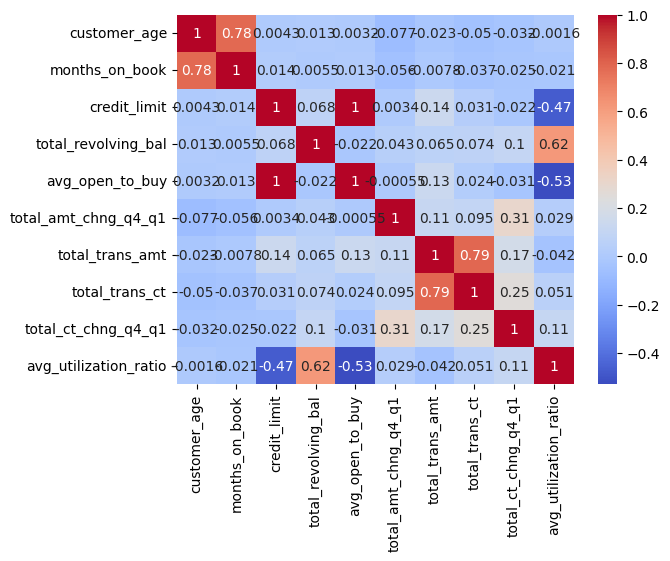

In [ ]:
corr1 = X_train[num].corr()
sns.heatmap(corr1, annot=True, cmap='coolwarm')

In [ ]:
# calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

num = X_train.select_dtypes(include = 'number').columns
cat = X_train.select_dtypes(include = 'object').columns

X = add_constant(X_train[num])

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df.sort_values(by = 'vif_score', axis = 0, ascending = False)

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


feature  vif_score
3            credit_limit        inf
4     total_revolving_bal        inf
5         avg_open_to_buy        inf
10  avg_utilization_ratio   2.910105
8          total_trans_ct   2.810709
7         total_trans_amt   2.773756
1            customer_age   2.591489
2          months_on_book   2.584340
9     total_ct_chng_q4_q1   1.181157
6    total_amt_chng_q4_q1   1.115876

Drop redundant feature

In [ ]:
X_train = X_train.drop(['credit_limit', 'total_revolving_bal','avg_open_to_buy'], axis = 1)
X_val = X_val.drop(['credit_limit', 'total_revolving_bal','avg_open_to_buy'], axis = 1)
X_test = X_test.drop(['credit_limit', 'total_revolving_bal','avg_open_to_buy'], axis = 1)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

num = X_train.select_dtypes(include = 'number').columns
cat = X_train.select_dtypes(include = 'object').columns

X = add_constant(X_train[num])

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df.sort_values(by = 'vif_score', axis = 0, ascending = False)

feature  vif_score
5         total_trans_ct   2.791950
4        total_trans_amt   2.711810
1           customer_age   2.591462
2         months_on_book   2.583671
6    total_ct_chng_q4_q1   1.179963
3   total_amt_chng_q4_q1   1.115650
7  avg_utilization_ratio   1.030388

# EDA

**1. Seperti apa distribusi usia para nasabah? Usia manakah yang cenderung memiliki kemungkinan churn terbesar?**

<Axes: xlabel='customer_age', ylabel='Count'>

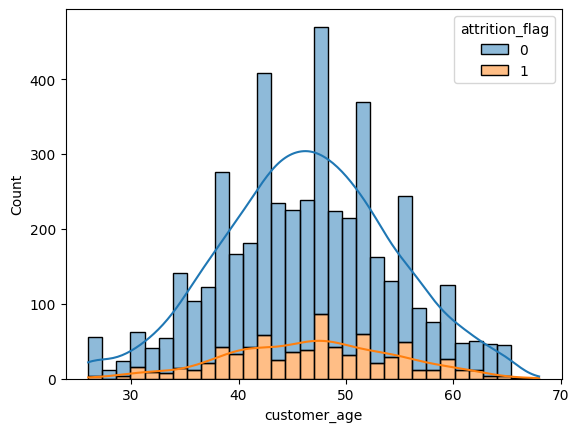

In [ ]:
sns.histplot(data=train, x='customer_age', hue='attrition_flag', multiple='stack', kde= True)

insight!!
- Customer dengan range umur 40 sampai 50 cenderung meninggalkan

**2. Apakah terdapat korelasi antara tingkat pendidikan dan income category? Bagaimana korelasi dari kedua prediktor tersebut terhadap churn?**

In [ ]:
pd.crosstab(df['education_level'], df['income_category'])

income_category  $120K +  $40K - $60K  $60K - $80K  $80K - $120K  \
education_level                                                    
College               69          173          118           160   
Doctorate             36           66           54            51   
Graduate             190          525          383           448   
High School          135          333          275           278   
Post-Graduate         28           99           72            74   
Uneducated           108          231          177           199   
Unknown              112          255          196           202   

income_category  Less than $40K  Unknown  
education_level                           
College                     332      107  
Doctorate                   153       67  
Graduate                   1087      313  
High School                 633      213  
Post-Graduate               161       45  
Uneducated                  494      175  
Unknown                     525      133

Mencari hubungan antara education level dengan income category

In [ ]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['education_level'], df['income_category'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}, p-value: {p}")

Chi-Square Statistic: 42.803432233595785, p-value: 0.06097413593157113


insight!!
- terdapat hubungan yang signifikan antara education level dengan income category. P value < 0,05!

Melihat distribusi data hubungan education level, income category dengan attrition flag!

In [ ]:
churn_analysis = df.groupby(['education_level', 'income_category'])['attrition_flag'].value_counts(normalize=True).unstack()
churn_analysis

attrition_flag                   Attrited Customer  Existing Customer
education_level income_category                                      
College         $120K +                   0.173913           0.826087
                $40K - $60K               0.138728           0.861272
                $60K - $80K               0.144068           0.855932
                $80K - $120K              0.206250           0.793750
                Less than $40K            0.147590           0.852410
                Unknown                   0.149533           0.850467
Doctorate       $120K +                   0.222222           0.777778
                $40K - $60K               0.166667           0.833333
                $60K - $80K               0.129630           0.870370
                $80K - $120K              0.196078           0.803922
                Less than $40K            0.274510           0.725490
                Unknown                   0.238806           0.761194
Graduate        $120K +                   0.168421           0.831579
                $40K - $60K               0.146667           0.853333
                $60K - $80K               0.133159           0.866841
                $80K - $120K              0.149554           0.850446
                Less than $40K            0.192272           0.807728
                Unknown                   0.153355           0.846645
High School     $120K +                   0.207407           0.792593
                $40K - $60K               0.147147           0.852853
                $60K - $80K               0.152727           0.847273
                $80K - $120K              0.143885           0.856115
                Less than $40K            0.157978           0.842022
                Unknown                   0.201878           0.798122
Post-Graduate   $120K +                   0.142857           0.857143
                $40K - $60K               0.161616           0.838384
                $60K - $80K               0.222222           0.777778
                $80K - $120K              0.229730           0.770270
                Less than $40K            0.204969           0.795031
                Unknown                   0.088889           0.911111
Uneducated      $120K +                   0.194444           0.805556
                $40K - $60K               0.177489           0.822511
                $60K - $80K               0.129944           0.870056
                $80K - $120K              0.185930           0.814070
                Less than $40K            0.159919           0.840081
                Unknown                   0.182857           0.817143
Unknown         $120K +                   0.169643           0.830357
                $40K - $60K               0.196078           0.803922
                $60K - $80K               0.158163           0.841837
                $80K - $120K              0.163366           0.836634
                Less than $40K            0.180952           0.819048
                Unknown                   0.203008           0.796992

In [ ]:
import numpy as np

# Cramér's V untuk churn dan education_level
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Korelasi education_level vs churn
conf_matrix_edu = pd.crosstab(df['education_level'], df['attrition_flag'])
cramers_v_edu = cramers_v(conf_matrix_edu)
print(f"Cramér's V (Education Level vs Churn): {cramers_v_edu}")

# Korelasi income_category vs churn
conf_matrix_income = pd.crosstab(df['income_category'], df['attrition_flag'])
cramers_v_income = cramers_v(conf_matrix_income)
print(f"Cramér's V (Income Category vs Churn): {cramers_v_income}")


Cramér's V (Education Level vs Churn): attrition_flag
Attrited Customer    0.087205
Existing Customer    0.039415
dtype: float64
Cramér's V (Income Category vs Churn): attrition_flag
Attrited Customer    0.077005
Existing Customer    0.034805
dtype: float64


insight!
- Education level dan pelanggan yang attrited memiliki korelasi yang cukup lemah, berada di angka 0.08
- Income category dengan pealnggan yang attrited memiliki korelasi yang cukup lemah, berada di angka 0.08
- Ecudation level dan income category memiliki korelai dengan attrited customer, namun cukup lemah

**3. Apakah terdapat perbedaan yang signifikan antara gender dengan kemungkinan nasabah untuk churn?**

<Axes: xlabel='gender', ylabel='count'>

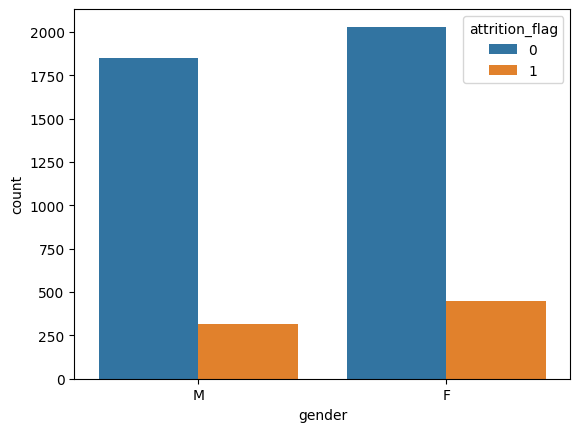

In [ ]:
sns.countplot(data=train, x='gender', hue='attrition_flag')

In [ ]:
from scipy.stats import ttest_ind

group1 = df[df['gender'] == 'M']['attrition_flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})
group2 = df[df['gender'] == 'F']['attrition_flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})

t_statistic, p_value = ttest_ind(group1, group2)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference between genders and attrition.")
else:
    print("There is no statistically significant difference between genders and attrition.")

T-statistic: -3.046199847623455
P-value: 0.002323905349977099
There is a statistically significant difference between genders and attrition.


Insight!
- terdapat perbedaan yang signifikan antara gender dengan attrition flag. Berdasarkan grafik barplot diatas. Perempuan cenderung lebih banyaj melakukan churn dibandingkan laki-laki

**4. Apakah semakin lama customer menjadi nasabah maka semakin kecil kemungkinan nasabah tersebut untuk churn?**

months_on_book

<Axes: xlabel='months_on_book', ylabel='Count'>

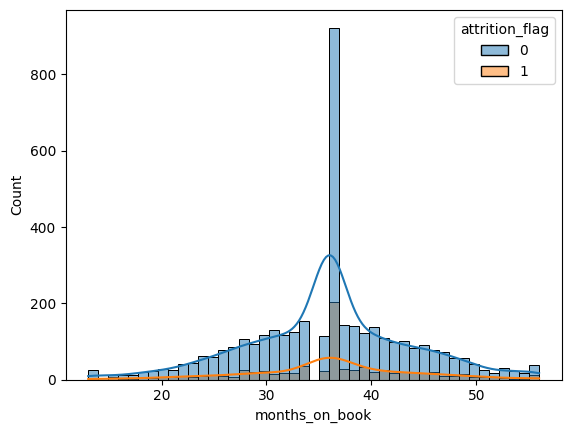

In [ ]:
sns.histplot(data=train, x='months_on_book', hue='attrition_flag', kde= True)

Semakin lama customer menjadi nasabah tidak menjadi jaminan bahwa kemungkinan churn semakin kecil. Terjadi lonjakan nasabah churn yang cukup signifikan pada bulan ke 35 mereka menjadi nasabah.

**5. Apakah semakin sering customer berinteraksi dengan bank dalam 1 tahun terakhir mempengaruhi besar atau kecilnya kemungkinan nasabah untuk churn?**

<Axes: xlabel='total_relationship_count', ylabel='Density'>

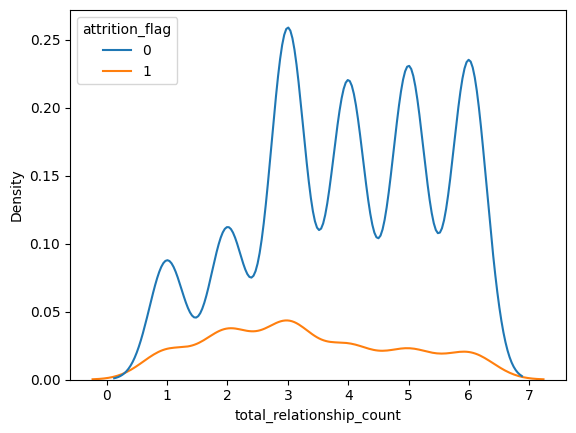

In [ ]:
sns.kdeplot(data=train, x='total_relationship_count', hue='attrition_flag')

<Axes: xlabel='total_relationship_count', ylabel='count'>

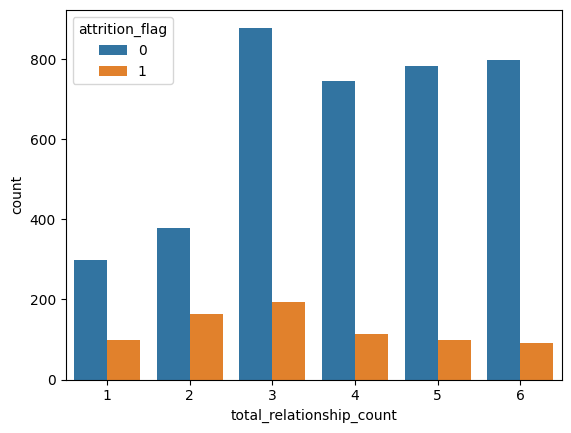

In [ ]:
sns.countplot(data=train, x='total_relationship_count', hue='attrition_flag')

In [ ]:
'''
from scipy.stats import ttest_ind



churn = train[train['attrition_flag'] == 1](['total_relationship_count'].astype(int))
retained = train[train['attrition_flag'] == 0](['total_relationship_count'].astype(int))

t_stat, p_value = ttest_ind(churn, retained, equal_var=False)
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")
'''

'\nfrom scipy.stats import ttest_ind\n\n\n\nchurn = train[train[\'attrition_flag\'] == 1]([\'total_relationship_count\'].astype(int))\nretained = train[train[\'attrition_flag\'] == 0]([\'total_relationship_count\'].astype(int))\n\nt_stat, p_value = ttest_ind(churn, retained, equal_var=False)\nprint(f"T-Statistic: {t_stat}, P-Value: {p_value}")\n'

Jumlah nasabah yang berinteraksi dengan bank selama satu tahun terakhir memiliki peraruh yang signifikant. Hal ini dibuktikan dengan T_test dengan p_value < 0,05. Terdapat pengaruh yang signifikan total_relation_ship_count dengan attrition_flag

# Preprocessing Data

## Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoders = {}
cat = X_train.select_dtypes(include = 'object').columns

# Fit and transform training data
for col in cat:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    encoders[col] = le  # Save the encoder for later use

# Transform validation and test data
for col in cat:
    le = encoders[col]  # Retrieve the encoder for this column
    X_val[col] = le.transform(X_val[col])
    X_test[col] = le.transform(X_test[col])

In [ ]:
X_train.head()

customer_age  gender  dependent_count  education_level  marital_status  \
2106            39       1                2                4               1   
5277            29       0                1                5               2   
2827            40       0                4                2               2   
7645            46       0                3                2               3   
3452            40       1                3                2               1   

      income_category  card_category  months_on_book  \
2106                2              0              36   
5277                4              0              36   
2827                4              3              27   
7645                4              0              33   
3452                2              0              27   

      total_relationship_count  months_inactive_12_mon  contacts_count_12_mon  \
2106                         5                       3                      2   
5277                         2                       2                      4   
2827                         2                       1                      2   
7645                         5                       3                      2   
3452                         3                       2                      3   

      total_amt_chng_q4_q1  total_trans_amt  total_trans_ct  \
2106                 0.465             1992              46   
5277                 0.625             2321              36   
2827                 0.847             3502              87   
7645                 0.450             4460              62   
3452                 0.483             1884              33   

      total_ct_chng_q4_q1  avg_utilization_ratio  
2106                0.704                  0.376  
5277                0.500                  0.919  
2827                0.933                  0.194  
7645                0.722                  0.823  
3452                0.435                  0.000

In [ ]:
X_val.head()

customer_age  gender  dependent_count  education_level  marital_status  \
256             43       1                4                6               2   
9759            44       1                3                3               3   
4470            38       0                3                3               1   
5825            47       0                3                6               2   
8422            53       1                3                6               1   

      income_category  card_category  months_on_book  \
256                 2              0              36   
9759                0              0              36   
4470                4              0              31   
5825                4              0              38   
8422                3              0              40   

      total_relationship_count  months_inactive_12_mon  contacts_count_12_mon  \
256                          3                       1                      0   
9759                         1                       3                      2   
4470                         3                       3                      2   
5825                         3                       2                      3   
8422                         1                       2                      3   

      total_amt_chng_q4_q1  total_trans_amt  total_trans_ct  \
256                  0.769             1348              34   
9759                 0.945             8260              54   
4470                 0.885             5245              89   
5825                 1.001             3511              64   
8422                 0.801             4350              76   

      total_ct_chng_q4_q1  avg_utilization_ratio  
256                 1.125                  0.043  
9759                0.500                  0.291  
4470                0.712                  0.000  
5825                0.882                  0.000  
8422                0.767                  0.000

## Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Unbalance Handling

In [ ]:
y_train.value_counts()

attrition_flag
0    3883
1     764
Name: count, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [ ]:
y_train_smote.value_counts()

attrition_flag
0    3883
1    3883
Name: count, dtype: int64

# Modelling

## XGBOOST

XGBOOST
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1632
           1       0.94      0.88      0.91       360

    accuracy                           0.97      1992
   macro avg       0.96      0.93      0.94      1992
weighted avg       0.97      0.97      0.97      1992



Text(0.5, 1.0, 'Confusion Matrix')

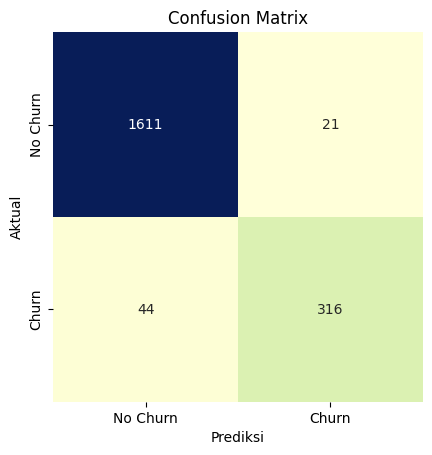

In [ ]:
# modeling_1
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
xgb_clf = XGBClassifier(random_state = 1000)

xgb_clf.fit(X_train, y_train)

#evaluation
y_val_pred = xgb_clf.predict(X_val)
print('XGBOOST')
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)

class_names = ['No Churn', 'Churn']

cmat_df = pd.DataFrame(cm, index=class_names, columns=class_names)

ax = sns.heatmap(cmat_df, square=True, annot=True, cbar=False, fmt='d', cmap="YlGnBu")
ax.set_xlabel('Prediksi')
ax.set_ylabel('Aktual')
ax.set_title("Confusion Matrix")

## Random Forest

RANDOM_FOREST
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1632
           1       0.94      0.81      0.87       360

    accuracy                           0.96      1992
   macro avg       0.95      0.90      0.92      1992
weighted avg       0.96      0.96      0.96      1992



Text(0.5, 1.0, 'Confusion Matrix')

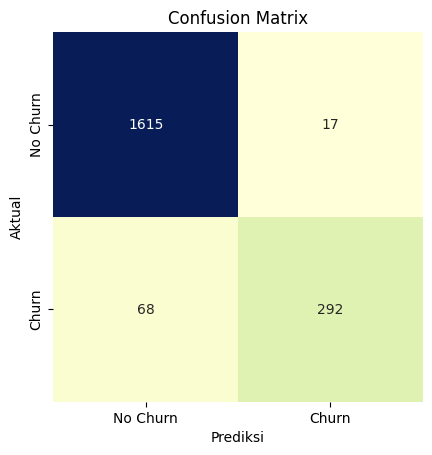

In [ ]:
# modeling_2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train,y_train)

#evaluation
y_val_pred = rf_clf.predict(X_val)
print('RANDOM_FOREST')
print(classification_report(y_val, y_val_pred))

y_val_pred = rf_clf.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)

class_names = ['No Churn', 'Churn']

cmat_df = pd.DataFrame(cm, index=class_names, columns=class_names)

ax = sns.heatmap(cmat_df, square=True, annot=True, cbar=False, fmt='d', cmap="YlGnBu")
ax.set_xlabel('Prediksi')
ax.set_ylabel('Aktual')
ax.set_title("Confusion Matrix")

### Tuning

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': (50,60,70,80,90,100,150),
    'max_depth':(5,6,7,10,15,20),
    'class_weight':('balanced', None)
}
rf_clf = RandomForestClassifier(random_state=42)

# note: we use recall
rf_clf_gridcv = GridSearchCV(rf_clf, parameters, cv=5, scoring='f1')
rf_clf_gridcv.fit(X_train_scaled, y_train)

CPU times: user 3min 52s, sys: 628 ms, total: 3min 53s
Wall time: 3min 59s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': ('balanced', None),
                         'max_depth': (5, 6, 7, 10, 15, 20),
                         'n_estimators': (50, 60, 70, 80, 90, 100, 150)},
             scoring='f1')

In [ ]:
# the results
cv_result = pd.DataFrame(rf_clf_gridcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

params  mean_test_score  \
75  {'class_weight': None, 'max_depth': 15, 'n_est...         0.851582   
83  {'class_weight': None, 'max_depth': 20, 'n_est...         0.849735   
76  {'class_weight': None, 'max_depth': 15, 'n_est...         0.849500   
70  {'class_weight': None, 'max_depth': 15, 'n_est...         0.849397   
74  {'class_weight': None, 'max_depth': 15, 'n_est...         0.848213   
..                                                ...              ...   
45  {'class_weight': None, 'max_depth': 5, 'n_esti...         0.708462   
48  {'class_weight': None, 'max_depth': 5, 'n_esti...         0.702661   
44  {'class_weight': None, 'max_depth': 5, 'n_esti...         0.701951   
43  {'class_weight': None, 'max_depth': 5, 'n_esti...         0.699096   
42  {'class_weight': None, 'max_depth': 5, 'n_esti...         0.689917   

    rank_test_score  
75                1  
83                2  
76                3  
70                4  
74                5  
..              ...  
45               80  
48               81  
44               82  
43               83  
42               84  

[84 rows x 3 columns]

RANDOM_FOREST
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1632
           1       0.94      0.81      0.87       360

    accuracy                           0.96      1992
   macro avg       0.95      0.90      0.92      1992
weighted avg       0.96      0.96      0.96      1992



Text(0.5, 1.0, 'Confusion Matrix')

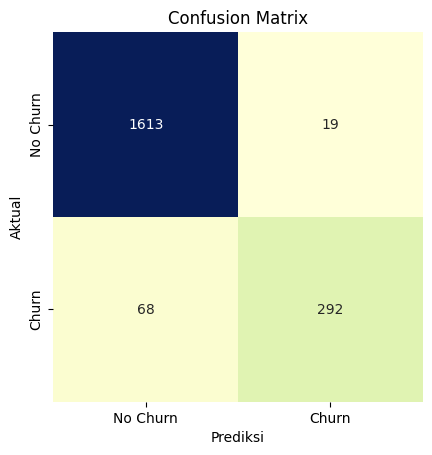

In [ ]:
# modeling_2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
rf_clf = RandomForestClassifier(n_estimators=100, max_depth = 15)
rf_clf.fit(X_train,y_train)

#evaluation
y_val_pred = rf_clf.predict(X_val)
print('RANDOM_FOREST')
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)

class_names = ['No Churn', 'Churn']

cmat_df = pd.DataFrame(cm, index=class_names, columns=class_names)

ax = sns.heatmap(cmat_df, square=True, annot=True, cbar=False, fmt='d', cmap="YlGnBu")
ax.set_xlabel('Prediksi')
ax.set_ylabel('Aktual')
ax.set_title("Confusion Matrix")

## LightGBM

In [ ]:
!pip install lightgbm

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 764, number of negative: 3883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 4647, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.164407 -> initscore=-1.625796
[LightGBM] [Info] Start training from score -1.625796
LIGHT_GBM
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1632
           1       0.95      0.87      0.91       360

    accuracy                           0.97      1992
   macro avg       0.96      0.93      0.94      1992
weighted avg       0.97      0.97      0.97      1992



Text(0.5, 1.0, 'Confusion Matrix')

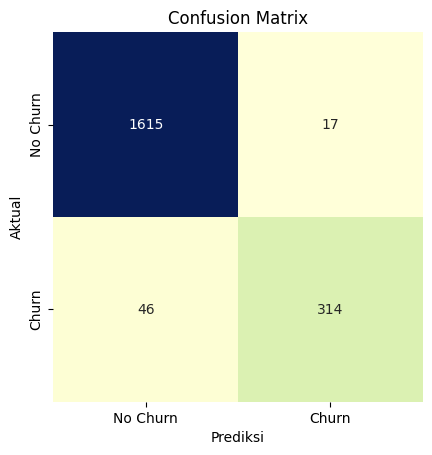

In [ ]:
# modeling_3
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
lgbm_clf = LGBMClassifier()
lgbm_clf.fit(X_train, y_train)

#evaluation
y_val_pred = lgbm_clf.predict(X_val)
print('LIGHT_GBM')
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)

class_names = ['No Churn', 'Churn']

cmat_df = pd.DataFrame(cm, index=class_names, columns=class_names)

ax = sns.heatmap(cmat_df, square=True, annot=True, cbar=False, fmt='d', cmap="YlGnBu")
ax.set_xlabel('Prediksi')
ax.set_ylabel('Aktual')
ax.set_title("Confusion Matrix")

# Evaluation

## XGBOOST

XGBOOST
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2361
           1       0.94      0.86      0.90       485

    accuracy                           0.97      2846
   macro avg       0.95      0.93      0.94      2846
weighted avg       0.97      0.97      0.97      2846



Text(0.5, 1.0, 'Confusion Matrix')

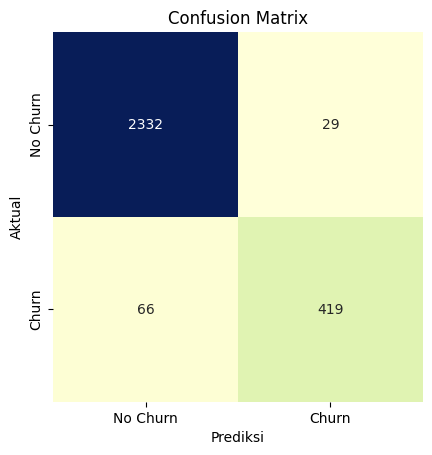

In [ ]:
y_test_pred_xgb = xgb_clf.predict(X_test)
print('XGBOOST')
print(classification_report(y_test, y_test_pred_xgb))

cm = confusion_matrix(y_test, y_test_pred_xgb)

class_names = ['No Churn', 'Churn']

cmat_df = pd.DataFrame(cm, index=class_names, columns=class_names)

ax = sns.heatmap(cmat_df, square=True, annot=True, cbar=False, fmt='d', cmap="YlGnBu")
ax.set_xlabel('Prediksi')
ax.set_ylabel('Aktual')
ax.set_title("Confusion Matrix")

In [ ]:
xgb_pred_proba = xgb_clf.predict_proba(X_test)

In [ ]:
# Extract feature importances
feature_importance = xgb_clf.feature_importances_

# Extract feature names from the training data
feature_names = X_train.columns

# Create a DataFrame to display feature importance
df_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort the DataFrame by feature importance
df_feature_importance = df_feature_importance.sort_values(by='Importance', ascending=False)
df_feature_importance

Feature  Importance
13            total_trans_ct    0.250166
8   total_relationship_count    0.164546
15     avg_utilization_ratio    0.125956
12           total_trans_amt    0.076421
1                     gender    0.064924
9     months_inactive_12_mon    0.060954
14       total_ct_chng_q4_q1    0.059463
0               customer_age    0.043158
11      total_amt_chng_q4_q1    0.027817
10     contacts_count_12_mon    0.027420
6              card_category    0.021734
2            dependent_count    0.021119
4             marital_status    0.018271
7             months_on_book    0.014226
3            education_level    0.012510
5            income_category    0.011317

## Random Forest

RANDOM_FOREST
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2361
           1       0.93      0.81      0.87       485

    accuracy                           0.96      2846
   macro avg       0.95      0.90      0.92      2846
weighted avg       0.96      0.96      0.96      2846



Text(0.5, 1.0, 'Confusion Matrix')

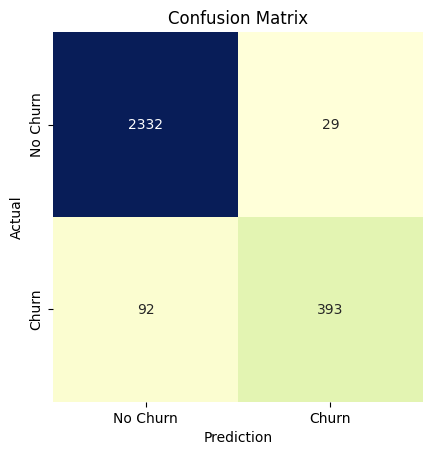

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_test_pred_rf = rf_clf.predict(X_test)
print('RANDOM_FOREST')
print(classification_report(y_test, y_test_pred_rf))

cm = confusion_matrix(y_test, y_test_pred_rf)

class_names = ['No Churn', 'Churn']

cmat_df = pd.DataFrame(cm, index=class_names, columns=class_names)

ax = sns.heatmap(cmat_df, square=True, annot=True, cbar=False, fmt='d', cmap="YlGnBu")
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')
ax.set_title("Confusion Matrix")

In [ ]:
rf_pred_proba = rf_clf.predict_proba(X_test)

In [ ]:
# Extract feature importances
feature_importance = rf_clf.feature_importances_

# Extract feature names from the training data
feature_names = X_train.columns

# Create a DataFrame to display feature importance
df_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort the DataFrame by feature importance
df_feature_importance = df_feature_importance.sort_values(by='Importance', ascending=False)
df_feature_importance

Feature  Importance
12           total_trans_amt    0.215284
13            total_trans_ct    0.188498
14       total_ct_chng_q4_q1    0.125080
15     avg_utilization_ratio    0.117840
8   total_relationship_count    0.083444
11      total_amt_chng_q4_q1    0.067618
0               customer_age    0.043698
7             months_on_book    0.029188
9     months_inactive_12_mon    0.027365
10     contacts_count_12_mon    0.027103
2            dependent_count    0.015813
1                     gender    0.015201
3            education_level    0.014943
5            income_category    0.013874
4             marital_status    0.011426
6              card_category    0.003624

## LightGBM

LIGHT_GBM
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2361
           1       0.93      0.84      0.89       485

    accuracy                           0.96      2846
   macro avg       0.95      0.92      0.93      2846
weighted avg       0.96      0.96      0.96      2846



Text(0.5, 1.0, 'Confusion Matrix')

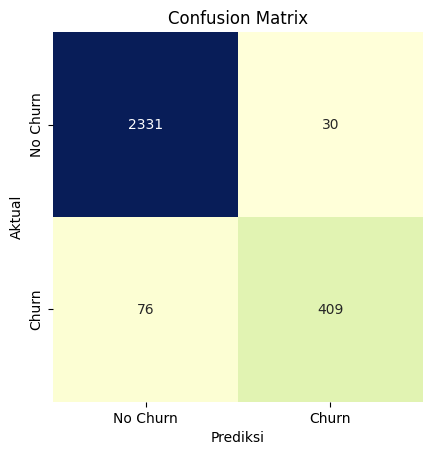

In [ ]:
y_test_pred_lgbm = lgbm_clf.predict(X_test)
print('LIGHT_GBM')
print(classification_report(y_test, y_test_pred_lgbm))

cm = confusion_matrix(y_test, y_test_pred_lgbm)

class_names = ['No Churn', 'Churn']

cmat_df = pd.DataFrame(cm, index=class_names, columns=class_names)

ax = sns.heatmap(cmat_df, square=True, annot=True, cbar=False, fmt='d', cmap="YlGnBu")
ax.set_xlabel('Prediksi')
ax.set_ylabel('Aktual')
ax.set_title("Confusion Matrix")

In [ ]:
lgbm_pred_proba = lgbm_clf.predict_proba(X_test)

In [ ]:
# Extract feature importances
feature_importance = lgbm_clf.feature_importances_

# Extract feature names from the training data
feature_names = X_train.columns

# Create a DataFrame to display feature importance
df_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort the DataFrame by feature importance
df_feature_importance = df_feature_importance.sort_values(by='Importance', ascending=False)
df_feature_importance

Feature  Importance
12           total_trans_amt         694
13            total_trans_ct         383
11      total_amt_chng_q4_q1         351
14       total_ct_chng_q4_q1         292
15     avg_utilization_ratio         237
0               customer_age         218
8   total_relationship_count         164
7             months_on_book         159
9     months_inactive_12_mon         137
10     contacts_count_12_mon         119
4             marital_status          54
3            education_level          50
2            dependent_count          49
1                     gender          37
5            income_category          37
6              card_category          19

## Evaluation Summary

# Model Agnostic Method

In [ ]:

## initiate explainer for XGB
churn_xgb_exp = dx.Explainer(xgb_clf, X_train, y_train, label = "XGB Interpretation")

## initiate explainer for Random Forest
churn_rf_exp = dx.Explainer(rf_clf, X_train, y_train, label = "RF Interpretation")

## initiate explainer for LighGBM
churn_lgbm_exp = dx.Explainer(lgbm_clf, X_train, y_train, label = "LGBM Interpretation")

Preparation of a new explainer is initiated

  -> data              : 4647 rows 16 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 4647 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGB Interpretation
  -> predict function  : <function yhat_proba_default at 0x79a31b16b6d0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 7.9e-07, mean = 0.164, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.209, mean = -8.08e-06, max = 0.194
  -> model_info        : package xgboost

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 4647 rows 16 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarr

## Feature Importance

### XGBOOST

In [ ]:
churn_xgb_exp.model_parts().plot()

Model XGboost 7 fitur sebagai ffeature impotant dengan drop loss diatas 0.002 pada setiap fitur penting. Dan menghiraukan 3 fitur lainnya. Fitur `total_trans_ct` dan `total_trans_amt` memiliki pengaruh yang signifikan terhadap prediksi model

### Random Forest

In [ ]:
churn_rf_exp.model_parts().plot()

Model Random Forest 5 fitur sebagai ffeature impotant dengan drop loss diatas 0.002 pada setiap fitur penting. Dan menghiraukan 6 fitur lainnya. Fitur `total_trans_ct` dan `total_trans_amt` memiliki pengaruh yang signifikan terhadap prediksi model

### LightGBM

In [ ]:
churn_lgbm_exp.model_parts().plot()

Model LightGBM 7 fitur sebagai ffeature impotant dengan drop loss diatas 0.002 pada setiap fitur penting. Dan menghiraukan 3 fitur lainnya. Fitur `total_trans_ct` dan `total_trans_amt` memiliki pengaruh yang signifikan terhadap prediksi model

## Partial Dependance plot

### XGBOOST

In [ ]:
churn_xgb_exp.model_profile().plot()

Calculating ceteris paribus:   0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:100: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[26.   26.42 26.84 ... 67.16 67.58 68.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

Calculating ceteris paribus:   6%|▋         | 1/16 [00:00<00:03,  4.30it/s]/usr/local/lib/python3.10/dist-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:100: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.   0.01 0.02 ... 0.98 0.99 1.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

Calculating ceteris paribus:  12%|█▎        | 2/16 [00:00<00:03,  4.22it/s]/usr/local/lib/python3.10/dist-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:

interpretaasi:
- Semakin banyak jumlah transaksi `total_trans_amt` maka peluang untuk customer churn semakin besar. Pada awalnya, saat nilai total_trans_amt rendah, probabilitas churn juga rendah. Namun, ketika nilai total_trans_amt meningkat (melebihi ambang tertentu), probabilitas churn justru naik signifikan, kemudian stabil pada level tertentu
- Semakin sering melakukan transaksi `total_trans_ct` maka peluang customer churn semakin kecil yang artinya customer akan loyal dan tetap menggunakan bank
- Semakin banyak pertambahan transaksi dari quarter 4 dan quarter 1 `total_ct_chng_q4_q1` maka peluang customer churn semakin kecil yang artinya customer akan loyal dan tetap menggunakan bank.

Evaluasi:
- cari tahu mengapa pelanggan lebih berpeluang melakukan churning pada jumlah transaksi yang besar. Apakah nasabah merasa tidak puas dengan pelayanan bank? atau mereka lebih memilih bank lain?

### Random Forest

In [ ]:
# create partial dependence plot of RF model
churn_rf_exp.model_profile().plot()

Calculating ceteris paribus:   0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:100: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[26.   26.42 26.84 ... 67.16 67.58 68.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

Calculating ceteris paribus:   6%|▋         | 1/16 [00:00<00:03,  4.36it/s]/usr/local/lib/python3.10/dist-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:100: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.   0.01 0.02 ... 0.98 0.99 1.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

Calculating ceteris paribus:  12%|█▎        | 2/16 [00:00<00:04,  3.46it/s]/usr/local/lib/python3.10/dist-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:

Interpretasi:
- `total_relationship_count` atau banyaknya produk yang digunakan nasabah di bank cukup berpengaruh seignifikan terhadap peluang mereka churn. Semakin banyak produk yang digunakan nasabaha di bank, maka peluang mereka untuk churn semakin kecil.
- `contact_count_12_months` semakin banyak interakhi antara nasabah dengan bank selama 12 bulan maka peluang nasabah untuk churn semakin besar, terdapat lonjakan peluang churn pada interaksi ke 6.
- Semakin banyak jumlah transaksi `total_trans_amt` maka peluang untuk customer churn semakin besar. Pada awalnya, saat nilai total_trans_amt rendah, probabilitas churn juga rendah. Namun, ketika nilai total_trans_amt meningkat (melebihi ambang tertentu), probabilitas churn justru naik signifikan, kemudian stabil pada level tertentu
- Semakin sering melakukan transaksi `total_trans_ct` maka peluang customer churn semakin kecil yang artinya customer akan loyal dan tetap menggunakan bank
- Semakin banyak pertambahan transaksi dari quarter 4 dan quarter 1 `total_ct_chng_q4_q1` maka peluang customer churn semakin kecil yang artinya customer akan loyal dan tetap menggunakan bank.
- Semakin banyak pertambahan nominal transaksi dari quarter 4 dan quarter 1 `total_amt_chng_q4_q1` maka peluang customer churn semakin kecil yang artinya customer akan loyal dan tetap menggunakan bank.

Evaluasi:
- Terus memberikan inovasi pada produk bank yang menarik dan dibutuhkan oleh nasabah yang dapat membuat nasabah lebih terikat dengan bank yang memperkecil kemungkinan mereka churn.
- Temukan root cause mengapa nasabah datang ke bank sampai berkali kali- apakah mereka menggunakan layanan bank atau mereka ingin complain terkait produk yang bank berikan dan belum terselesaikan?
- cari tahu mengapa pelanggan lebih berpeluang melakukan churning pada jumlah transaksi yang besar. Apakah nasabah merasa tidak puas dengan pelayanan bank? atau mereka lebih memilih bank lain?
- Mencari tahu apa yang menyebabkan nasabah mempercayai bank sehingga nasabah meningkatkan transaksi mereka dan jumlah transaksi dari quarter 4 sampai quarter 1. Pertahankan itu

### LightGBM

In [ ]:
# create partial dependence plot of LGBM model
churn_lgbm_exp.model_profile().plot()

Calculating ceteris paribus:   0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:100: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[26.   26.42 26.84 ... 67.16 67.58 68.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

Calculating ceteris paribus:   6%|▋         | 1/16 [00:00<00:04,  3.46it/s]/usr/local/lib/python3.10/dist-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:100: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.   0.01 0.02 ... 0.98 0.99 1.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

Calculating ceteris paribus:  12%|█▎        | 2/16 [00:00<00:03,  3.68it/s]/usr/local/lib/python3.10/dist-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:

Interpretasi:
- `total_relationship_count` atau banyaknya produk yang digunakan nasabah di bank cukup berpengaruh seignifikan terhadap peluang mereka churn. Semakin banyak produk yang digunakan nasabaha di bank, maka peluang mereka untuk churn semakin kecil.
- `contact_count_12_months` semakin banyak interakhi antara nasabah dengan bank selama 12 bulan maka peluang nasabah untuk churn semakin besar, terdapat lonjakan peluang churn pada interaksi ke 6.
- Semakin banyak jumlah transaksi `total_trans_amt` maka peluang untuk customer churn semakin besar. Pada awalnya, saat nilai total_trans_amt rendah, probabilitas churn juga rendah. Namun, ketika nilai total_trans_amt meningkat (melebihi ambang tertentu), probabilitas churn justru naik signifikan, kemudian stabil pada level tertentu
- Semakin sering melakukan transaksi `total_trans_ct` maka peluang customer churn semakin kecil yang artinya customer akan loyal dan tetap menggunakan bank
- Semakin banyak pertambahan transaksi dari quarter 4 dan quarter 1 `total_ct_chng_q4_q1` maka peluang customer churn semakin kecil yang artinya customer akan loyal dan tetap menggunakan bank.
- Semakin banyak pertambahan nominal transaksi dari quarter 4 dan quarter 1 `total_amt_chng_q4_q1` maka peluang customer churn semakin kecil yang artinya customer akan loyal dan tetap menggunakan bank.

Evaluasi:
- Terus memberikan inovasi pada produk bank yang menarik dan dibutuhkan oleh nasabah yang dapat membuat nasabah lebih tetikan dengan bank yang memperkecil kemungkinan mereka churn.
- Temukan root cause mengapa nasabah datang ke bank sampai berkali kali- apakah mereka menggunakan layanan bank atau mereka ingin complain terkait produk yang bank berikan dan belum terselesaikan?
- cari tahu mengapa pelanggan lebih berpeluang melakukan churning pada jumlah transaksi yang besar. Apakah nasabah merasa tidak puas dengan pelayanan bank? atau mereka lebih memilih bank lain?
- Mencari tahu apa yang menyebabkan nasabah mempercayai bank sehingga nasaah meningkatkan transaksi mereka dan jumlah transaksi dari quarter 4 sampai quarter 1. Pertahankan itu

## LIME

In [ ]:
# define Random Forest explainer with lime module
lime_explainer = LimeTabularExplainer(
    X_train.values,
    feature_names = X_train.columns.tolist(),
    class_names = ['Existing_Customer', 'Attrited_Customer'],
    discretize_continuous = True,
    verbose = True
)

### XGBOOST

In [ ]:
y_train.iloc[55], y_test_pred_xgb[55]

(0, 1)

In [ ]:
user_id_XX = X_train.iloc[0]

In [ ]:
lime_explainer.explain_instance(user_id_XX, xgb_clf.predict_proba).show_in_notebook(show_table=True)

Intercept 0.3487740237302182
Prediction_local [0.01674264]
Right: 0.0075230566


/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning:

Series.__getitem__ 

### Random Forest

In [ ]:
y_train.iloc[0], y_test_pred_rf[0]

(0, 0)

In [ ]:
user_id_XX = X_train.iloc[0]

In [ ]:
# explain Random Forest prediction for user_id: XX
lime_explainer.explain_instance(user_id_XX, rf_clf.predict_proba).show_in_notebook(show_table=True)

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning:

X does not have valid fe

Intercept 0.3174986919693268
Prediction_local [0.14267431]
Right: 0.03


/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:427: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



### LightGBM

In [ ]:
y_train.iloc[0], y_test_pred_lgbm[0]

(0, 0)

In [ ]:
user_id_XX = X_train.iloc[0]

In [ ]:
lime_explainer.explain_instance(user_id_XX, lgbm_clf.predict_proba).show_in_notebook(show_table=True)

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Intercept 0.2929161621453045
Prediction_local [0.11314469]
Right: 0.008809002006682835


/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:427: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



## Shapley

### XGBOOST

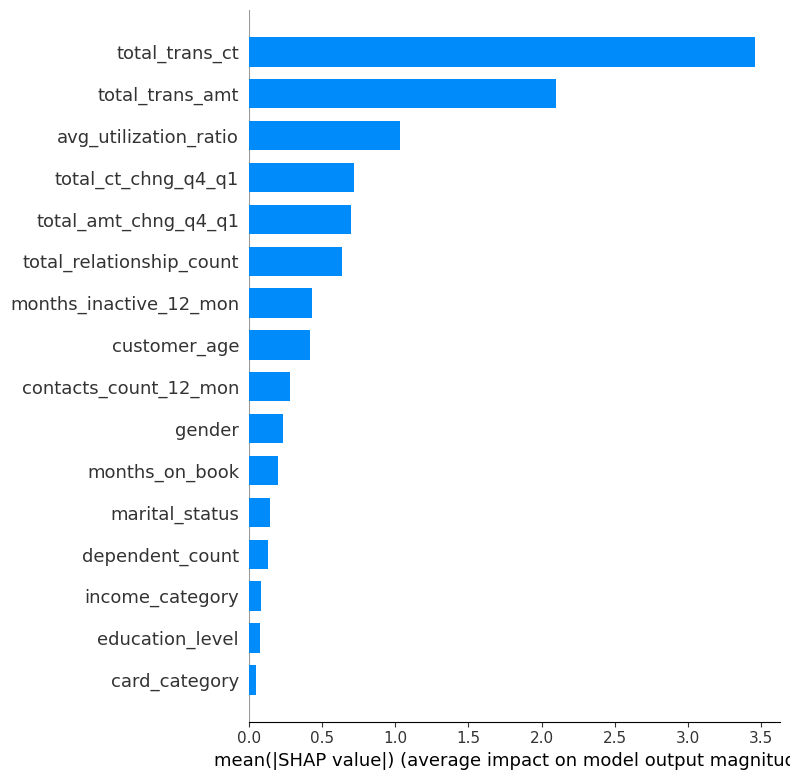

In [ ]:
# create SHAP Tree Explainer for XGBoost model with| first 1000 rows of train data
xgb_shap_values = shap.TreeExplainer(xgb_clf).shap_values(X_train[:1000])

# create SHAP summary plot with next 1000 rows of train data
shap.summary_plot(xgb_shap_values, X_train[1000:2000], plot_type='bar')

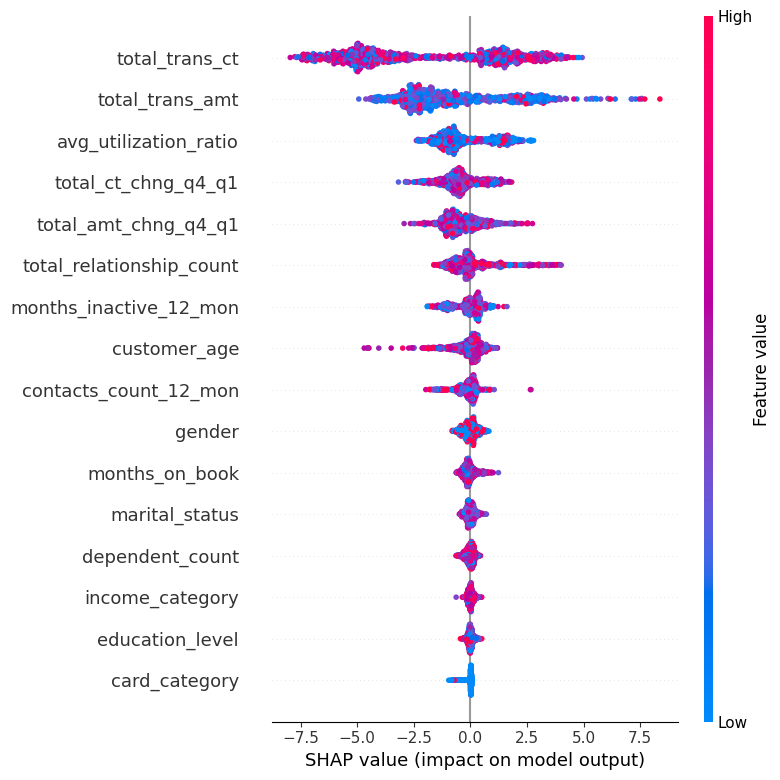

In [ ]:
# create SHAP summary plot to visualize impact distribution of next 1000 rows of train data
shap.summary_plot(xgb_shap_values, X_train[1000:2000])

### Random Forest

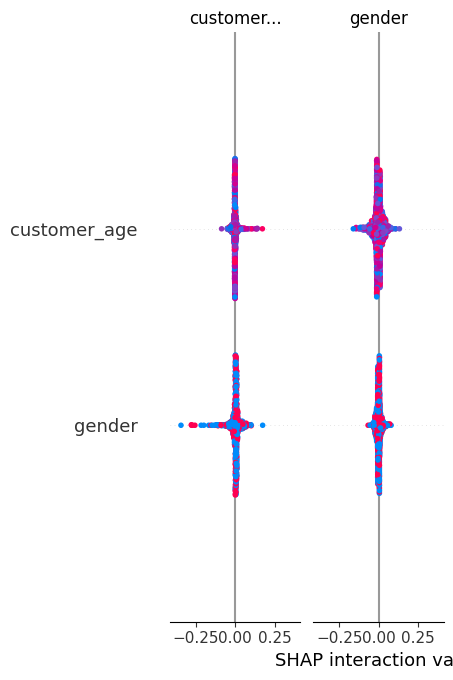

In [ ]:
# create SHAP Tree Explainer for Random Forest model with| first 1000 rows of train data
rf_shap_values = shap.TreeExplainer(rf_clf).shap_values(X_train[:1000])

# create SHAP summary plot with next 1000 rows of train data
shap.summary_plot(rf_shap_values, X_train[1000:2000], plot_type='bar')

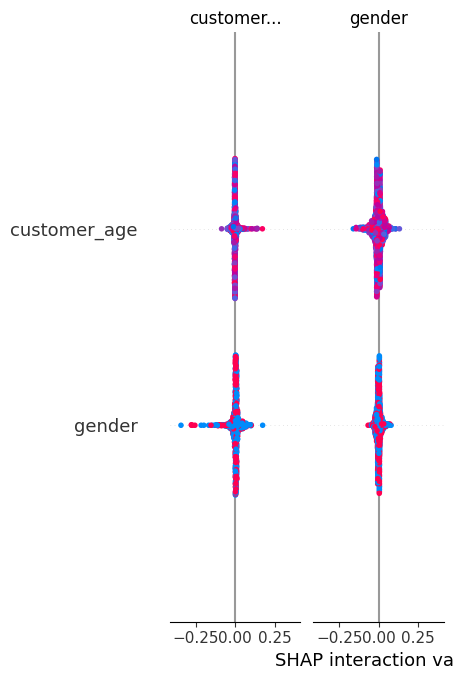

In [ ]:
# create SHAP summary plot to visualize impact distribution of next 1000 rows of train data
shap.summary_plot(rf_shap_values, X_train[1000:2000])

### LightGBM

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



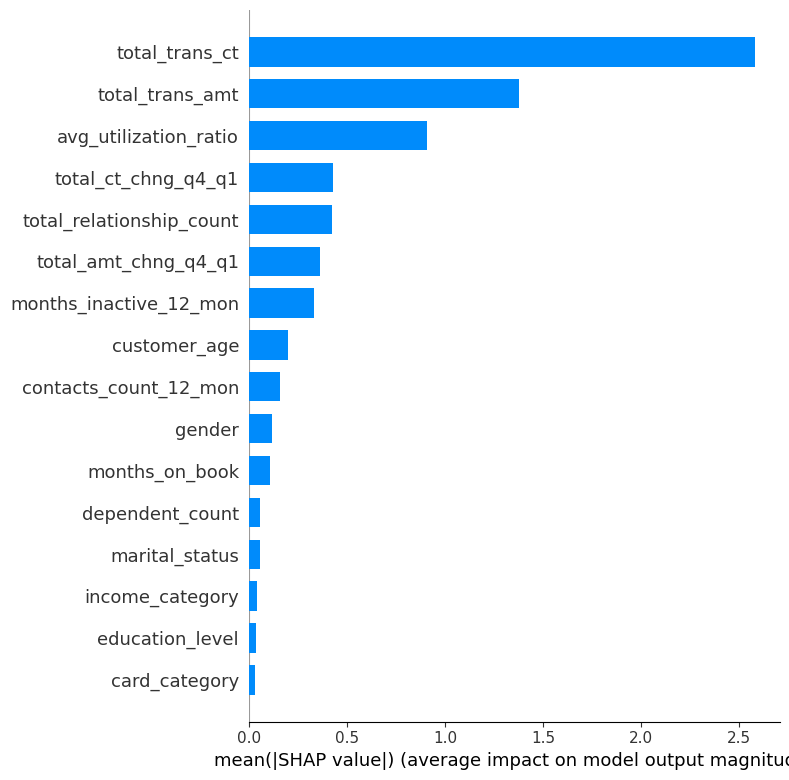

In [ ]:
# create SHAP Tree Explainer for LightGBM  model with| first 1000 rows of train data
lgbm_shap_values = shap.TreeExplainer(lgbm_clf).shap_values(X_train[:1000])

# create SHAP summary plot with next 1000 rows of train data
shap.summary_plot(lgbm_shap_values, X_train[1000:2000], plot_type='bar')

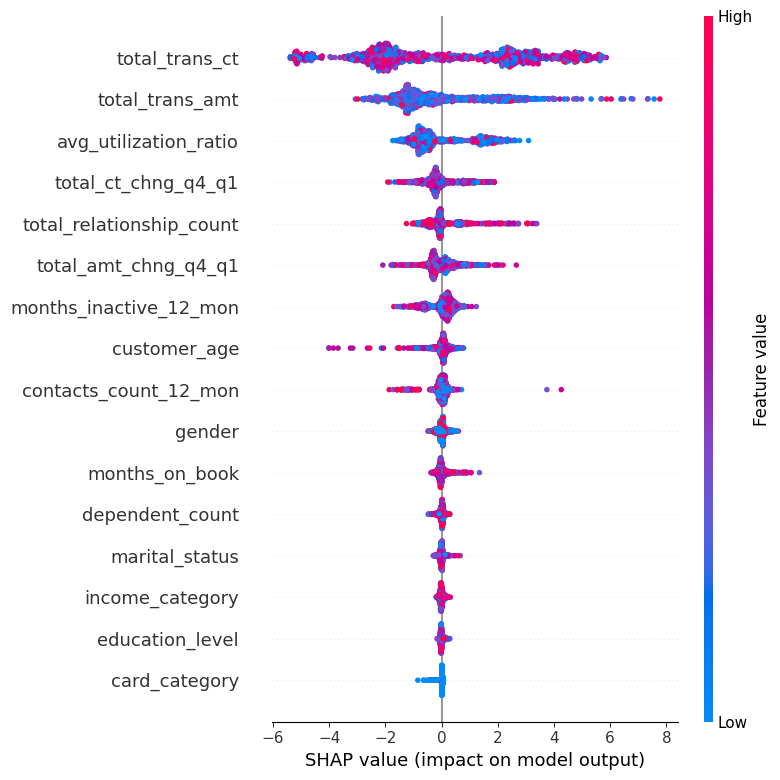

In [ ]:
# create SHAP summary plot to visualize impact distribution of next 1000 rows of train data
shap.summary_plot(lgbm_shap_values, X_train[1000:2000])

# SUMMARY and Recomendation

3. Anda ingin meyakinkan stakeholder anda bahwa model yang anda gunakan itu akan lebih baik dalam mengidentifikasi customer yang akan churn dibandingkan tanpa menggunakan model. Apa metrik yang dapat anda gunakan untuk membuktikan hal ini?



Pada kasus prediksi customer churn pada bank, matriks yang digunakan pada evaluasi adalah recall, F1 Score dan accuracy. Pelilihan matriks recall dikarenakan kita ingin mengidentifikaisi sebanyak mungkin customer yang benar-benar churn untuk menangkap pola apa saja yang membuat mereka churn, f1 score dipilih karena kita tidak hanya ingin hanya memfokuskan menangkap sebanyak mungkin customer yang churn secara aktual tapi jua ingin mengetahui performa model kita dalam memprediksi (matriks precision, hasil observasi prediksi) maka dari itu f1 score dibutuhkan untuk mengharmonisasi antara recall dan precission. Yang terakhir, matriks akurasi dipilih karena matriks ini merupakan performa rata-rata dari model dalam memprediksi.

Model extreme dradient boosting memiliki performa yang paling baik diantara random forest dan Light Gradient Boosting. Hal ini dibuktikan dengan clasification report pada data testing dengan nilai sebagai berikut:
- Accuracy = 97%
- Recall = 86%.
- F1_score = 90%
- precision = 94%
 Pada kelas 1 atau customer yang churn. Karena kita ingin memfokuskan pada customer churn prediction.

4. Karena stakeholder anda membutuhkan knowledge dari model, analisislah model yang anda buat dengan menggunakan explanatory model analysis dan buatlah rekomendasi-rekomendasi berdasarkan hasil dari analisis tersebu

Model yang bagus belum tentu memiliki reason yang kuat dapat menginterpretasikan model. UNtuk dapat menginterpretasikan model, digunakan explainable ai untuk menjelaskan ensemble model seperi xgboost, lightgbm dan random forest. Model XAI yang digunakan adalah permutable feature importance dan Partial dependance plot.

Setelah dilakukan model xgboost, random forest dan lightgbm dijelaskan menggunakan XAI permutable feature importance dan partial dependance. Model RANODM FOREST memiliki reason yang lebih baik dan dapat memberikan interpretasi yang lebih baik dibandingkan XGBOOST walaupun model ini memiliki performa yang baik dalam segi nilai matriks.

Hasil Interpretasi XAI menggunakan partial dependance pada model RANDOM FOREST dan LIGHTGBM memiliki interpretais yang hakim mirip. Fitur yang diperhitungkan hampir mirip. Namun pada model RANDOM FOREST, setiap keaikan nilai pada fitur memiliki pengaruh yang signifikan terhadap peluang customer churn dan loyal. Namun pada model LIGHTGBM, kenaikan nilai pada fitur tidak memiliki pengaruh yang signifikan terhadap peluang customer untuk churn, cenderung nilai fari peluang customer churn stagnan sampai pada titik tertentu kemudian terjadi lonjakan.

Berikut adalah insight dan Business Recomendation dan didapat dari model Random Forest menggunakan XAI Permutable feature importance dan partial dependance plot.
Insight:
- Model Random Forest 5 fitur sebagai feature impotant dengan drop loss diatas 0.002 pada setiap fitur penting. Dan menghiraukan 6 fitur lainnya.
- Fitur total_trans_ct dan total_trans_amt memiliki pengaruh yang signifikan terhadap prediksi model.

Interpretasi XAI:
- `total_relationship_count` atau banyaknya produk yang digunakan nasabah di bank cukup berpengaruh seignifikan terhadap peluang mereka churn. Semakin banyak produk yang digunakan nasabaha di bank, maka peluang mereka untuk churn semakin kecil.
- `contact_count_12_months` semakin banyak interakhi antara nasabah dengan bank selama 12 bulan maka peluang nasabah untuk churn semakin besar, terdapat lonjakan peluang churn pada interaksi ke 6.
- Semakin banyak jumlah transaksi `total_trans_amt` maka peluang untuk customer churn semakin besar. Pada awalnya, saat nilai total_trans_amt rendah, probabilitas churn juga rendah. Namun, ketika nilai total_trans_amt meningkat (melebihi ambang tertentu), probabilitas churn justru naik signifikan, kemudian stabil pada level tertentu
- Semakin sering melakukan transaksi `total_trans_ct` maka peluang customer churn semakin kecil yang artinya customer akan loyal dan tetap menggunakan bank
- Semakin banyak pertambahan transaksi dari quarter 4 dan quarter 1 `total_ct_chng_q4_q1` maka peluang customer churn semakin kecil yang artinya customer akan loyal dan tetap menggunakan bank.
- Semakin banyak pertambahan nominal transaksi dari quarter 4 dan quarter 1 `total_amt_chng_q4_q1` maka peluang customer churn semakin kecil yang artinya customer akan loyal dan tetap menggunakan bank.

Business Recomendation
- Terus memberikan inovasi pada produk bank yang menarik dan dibutuhkan oleh nasabah yang dapat membuat nasabah lebih terikat dengan bank yang memperkecil kemungkinan mereka churn.
- Temukan root cause mengapa nasabah datang ke bank sampai berkali-kali. Apakah mereka menggunakan layanan bank atau mereka ingin complain terkait produk yang bank berikan dan belum terselesaikan?
- Cari tahu mengapa pelanggan lebih berpeluang melakukan churning pada jumlah transaksi yang besar. Apakah nasabah merasa tidak puas dengan pelayanan bank? atau mereka lebih memilih bank lain?
- Mencari tahu apa yang menyebabkan nasabah mempercayai bank sehingga nasabah meningkatkan transaksi mereka dan jumlah transaksi dari quarter 4 sampai quarter 1. Pertahankan itu karena peningkaan jumlah transaksi dan nominal transaksi memperkecil peluang nasabah untuk churn.



Dari hasil interpretasi dengan XAI, maka saya merekomendasikan pengguna